In [1]:
import pandas as pd

import re
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
# Define the file path
file_path = 'data/news_title_train1001.csv'

# Get the total number of rows (for tqdm progress bar)
total_rows = sum(1 for row in open(file_path, 'r')) - 1  # Minus 1 for header

# Set the chunk size
chunk_size = 10000

# Initialize an empty list to store the chunks
chunks = []

# Read the CSV file in chunks and show progress using tqdm
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(chunk_size)

# Concatenate all the chunks into a single DataFrame
news = pd.concat(chunks, ignore_index=True)

# Display the first few rows of the DataFrame
news

# 총 4분

Loading CSV: 4960000rows [00:15, 313768.20rows/s]                               


,sentence,board,write_date,source_site,field
0,트럼프 '5월 예루살렘 美대사관 개소 때 직접 방문 가능',기타_기타,2018-03-06,뉴시스,취미
1,"틸러슨, 6일부터 아프리카 순방…트럼프 '거지소굴' 발언 뒷처리",기타_기타,2018-03-06,뉴시스,취미
2,사우디 정부 '이혼한 여성에게 자녀 친권 우선권 부여',기타_기타,2018-03-13,뉴시스,취미
3,"'eu, 브렉시트 후에도 英에 ecj 관할권 수용 요구할 듯' ft",기타_기타,2018-02-27,뉴시스,취미
4,"트럼프 '美 국무부 인력난, 민주당 인준 방해 탓'",기타_기타,2018-03-12,뉴시스,취미
...,...,...,...,...,...
4955960,경기 북부 호우특보에 '호우주의'도…서울 시간당 80㎜ 큰비,사회_날씨/재해,2020-08-01,뉴스1,사건사고
4955961,[퇴근길 날씨] 한증막 열기에 오늘 밤도 열대야…전주·홍성 호우주의보,사회_날씨/재해,2020-08-31,뉴스1,사건사고
4955962,[내일 날씨] 중부지방 최대 500㎜ '폭우'…남부도 100㎜(종합),사회_날씨/재해,2020-08-08,뉴스1,사건사고
4955963,[오늘 날씨] 태풍 '바비' 가지만 낮까지 강풍…남부 33도 더위,사회_날씨/재해,2020-08-27,뉴스1,사건사고


## 전처리
- '(서울=뉴스1) (이름) 기자 =' 반복되는 포멧 삭제
- 언론사, 날짜별 고르게 데이터 수집되었는지 확인

In [4]:
# 긴 컬럼 내용을 생략하지 않고 모두 표시
pd.set_option('display.max_colwidth', None)

In [5]:
# 법률안 보고서 기간 기준 슬라이싱

news['write_date'] = pd.to_datetime(news['write_date'])

# Define the date range
start_date = '2014-01-12'
end_date = '2022-07-27'

# Filter the DataFrame to include only rows within the specified date range
news = news[(news['write_date'] >= start_date) & (news['write_date'] <= end_date)]

news

,sentence,board,write_date,source_site,field
0,트럼프 '5월 예루살렘 美대사관 개소 때 직접 방문 가능',기타_기타,2018-03-06,뉴시스,취미
1,"틸러슨, 6일부터 아프리카 순방…트럼프 '거지소굴' 발언 뒷처리",기타_기타,2018-03-06,뉴시스,취미
2,사우디 정부 '이혼한 여성에게 자녀 친권 우선권 부여',기타_기타,2018-03-13,뉴시스,취미
3,"'eu, 브렉시트 후에도 英에 ecj 관할권 수용 요구할 듯' ft",기타_기타,2018-02-27,뉴시스,취미
4,"트럼프 '美 국무부 인력난, 민주당 인준 방해 탓'",기타_기타,2018-03-12,뉴시스,취미
...,...,...,...,...,...
4955960,경기 북부 호우특보에 '호우주의'도…서울 시간당 80㎜ 큰비,사회_날씨/재해,2020-08-01,뉴스1,사건사고
4955961,[퇴근길 날씨] 한증막 열기에 오늘 밤도 열대야…전주·홍성 호우주의보,사회_날씨/재해,2020-08-31,뉴스1,사건사고
4955962,[내일 날씨] 중부지방 최대 500㎜ '폭우'…남부도 100㎜(종합),사회_날씨/재해,2020-08-08,뉴스1,사건사고
4955963,[오늘 날씨] 태풍 '바비' 가지만 낮까지 강풍…남부 33도 더위,사회_날씨/재해,2020-08-27,뉴스1,사건사고


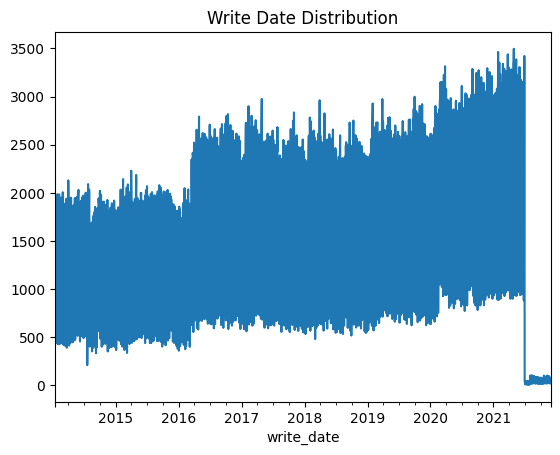

In [6]:
# 날짜별 데이터 고르게 되어있는지 확인

news['write_date'].value_counts().sort_index().plot(kind='line')
plt.title('Write Date Distribution')
plt.show()

# 해보니 훅 떨어지는 날짜가 있음

In [7]:
# 훅 떨어지는 날짜 확인 후 그외 부분 슬라이싱
# Count the number of news articles per date
news_count_by_date = news['write_date'].value_counts().sort_index()

# Find the first date where the count of news articles drops below 100
drop_below_100_date = news_count_by_date[news_count_by_date < 100].index[0]

# Display the first date where the count drops below 100
print(f"The first date where the news count drops below 100 is: {drop_below_100_date}")

The first date where the news count drops below 100 is: 2021-07-01 00:00:00


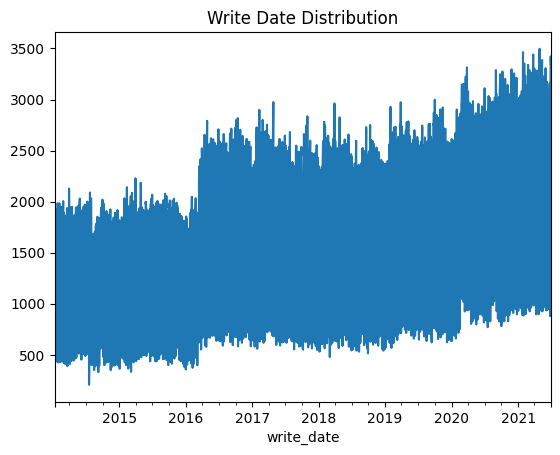

In [8]:
# Slice the data to include only articles before that date
news = news[news['write_date'] < drop_below_100_date]

# 그 뒤로 다시 그려봐
news['write_date'].value_counts().sort_index().plot(kind='line')
plt.title('Write Date Distribution')
plt.show()

In [9]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'

# 음수 표시를 위한 설정
plt.rcParams['axes.unicode_minus'] = False

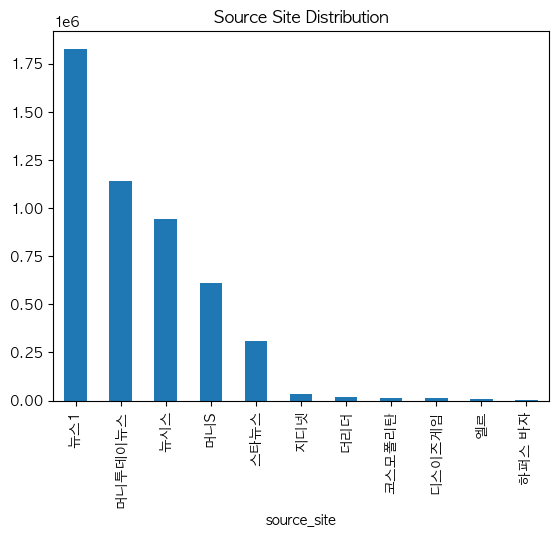

In [10]:
# 언론사별 데이터 고르게 되어있는지 확인

news['source_site'].value_counts().plot(kind='bar')
plt.title('Source Site Distribution')
plt.show()

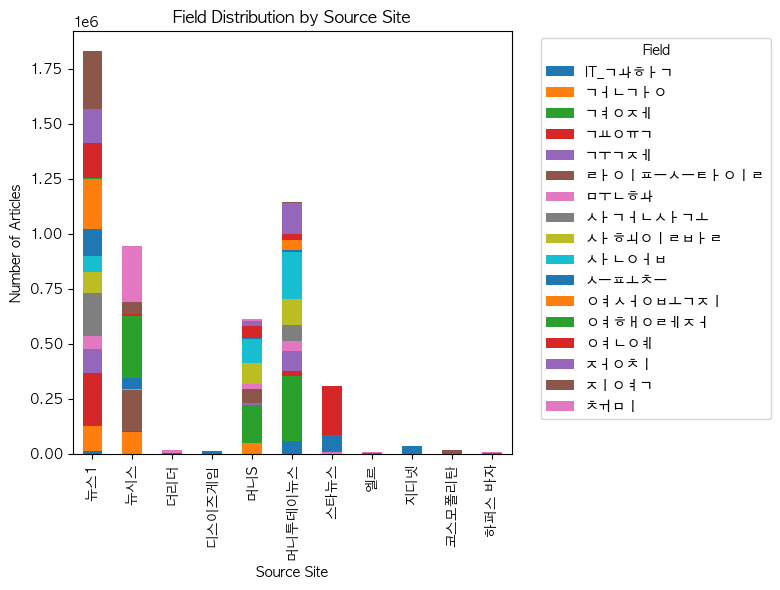

In [11]:
# 언론사별 필드는 고르게 되어있는가?

# Group by 'source_site' and 'field' and count occurrences
field_distribution = news.groupby(['source_site', 'field']).size().unstack(fill_value=0)

# Plot the distribution as a bar chart
field_distribution.plot(kind='bar', stacked=True, figsize=(8, 6))

# Add titles and labels
plt.title('Field Distribution by Source Site')
plt.xlabel('Source Site')
plt.ylabel('Number of Articles')
plt.legend(title='Field', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

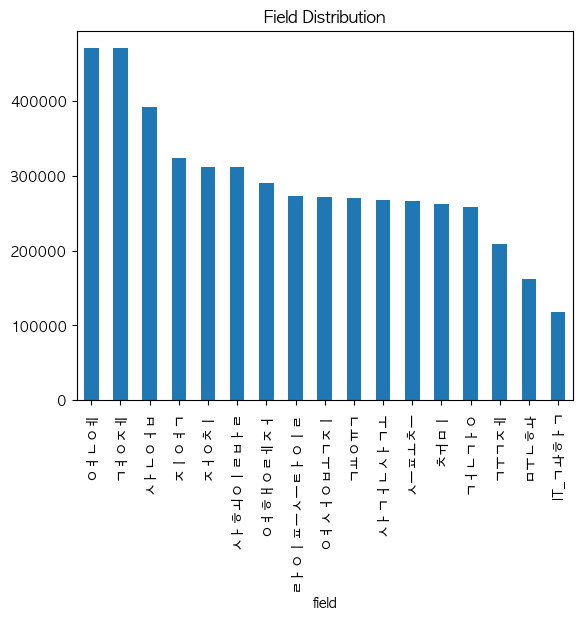

In [12]:
# 필드별 데이터 고르게 되어있는지 확인

news['field'].value_counts().plot(kind='bar')
plt.title('Field Distribution')
plt.show()

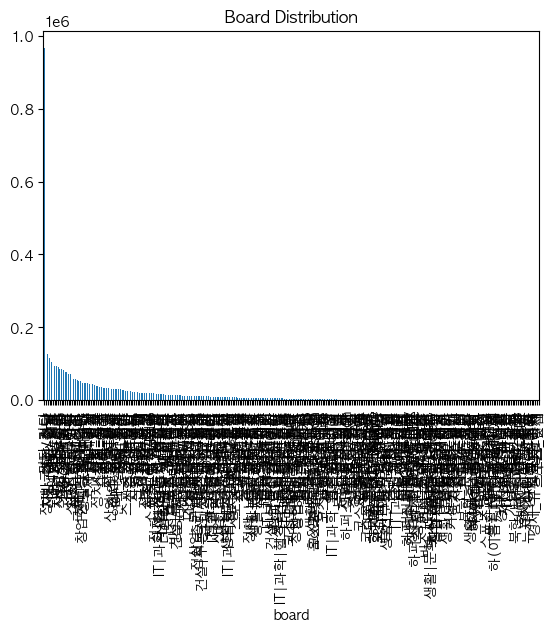

In [13]:
# 필드별 데이터 고르게 되어있는지 확인

news['board'].value_counts().plot(kind='bar')
plt.title('Board Distribution')
plt.show()

In [14]:
news['board'].value_counts()

board
기타_기타         965828
정치_국회ㆍ정당      140284
지방_대전/충남      126237
지방_광주/전남      117220
증권_종목         104967
               ...  
연예_미디어             4
문화_전시              2
경제_유통/생활경제         2
스포츠_연재             1
푸드_맛집              1
Name: count, Length: 287, dtype: int64

In [15]:
len(news['board'].value_counts())

287

### 스케일링 및 노멀라이제이션 결론 
- 언론사별로 특정 필드만 엄청 많이 다루는 언론사가 없어서 굳이 샘플링 안해줘도 될듯
- 필드를 똑같이 맞춰주면 어떤 필드가 많이 주목을 받는지 모르기 때문에, 해당 필드가 많이 언급된다고,
- 노멀라이제이션 해주어서는 안될듯

##### - 그런데 여전히 뉴스 개수의 상승세가 있으므로 단순히 빈도수..로 해야할지 혹은 빈도의 확률로 해야할지는 의문

In [16]:
news.to_csv('data/news_title_sliced', index=False)
# 기간 슬라이싱만 된 데이터
# 5분 걸림

## TF-IDF 키워드 추출

In [42]:
# Threshold를 지정하기 위해 어느정도의 키워드가 나오는지 확인하기 위해 처음 50개만 우선 적용
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample the first 50 rows for testing
sample_news = news[:50]

# Initialize tqdm for pandas
tqdm.pandas()

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=10000, stop_words='english')

# Fit and transform the cleaned sentences with progress bar
tfidf_matrix = tfidf_vectorizer.fit_transform(tqdm(sample_news['sentences'], desc="TF-IDF Processing"))

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to extract keywords with TF-IDF scores above a certain threshold
def extract_keywords_by_threshold(row_idx, tfidf_matrix, feature_names, threshold=0.3):
    # Get the TF-IDF scores for the document
    tfidf_scores = tfidf_matrix[row_idx].T.todense()
    
    # Create a list of words with their TF-IDF scores
    word_scores = [(feature_names[i], tfidf_scores[i, 0]) for i in range(len(feature_names))]
    
    # Filter words by threshold
    filtered_word_scores = [(word, score) for word, score in word_scores if score >= threshold]
    
    # Return the filtered words
    return [word for word, score in filtered_word_scores]

# Apply the function to each row in the sample DataFrame and set threshold, with tqdm progress bar
threshold_value = 0.2
sample_news['filtered_keywords'] = [extract_keywords_by_threshold(i, tfidf_matrix, feature_names, threshold=threshold_value) for i in tqdm(range(tfidf_matrix.shape[0]), desc="Keyword Extraction")]


Keyword Extraction: 100%|██████████████████████| 50/50 [00:00<00:00, 189.16it/s]
/var/folders/1w/94w03vcn7rv_gpwvy1gmzjhw0000gn/T/ipykernel_3966/2067015734.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_news['filtered_keywords'] = [extract_keywords_by_threshold(i, tfidf_matrix, feature_names, threshold=threshold_value) for i in tqdm(range(tfidf_matrix.shape[0]), desc="Keyword Extraction")]


In [41]:
# threshold 0.15
sample_news

,sentences,source_site,write_date,field,filtered_keywords
0,【워싱턴=신화/뉴시스】(이름) 기자 = 도널드 트럼프 미 대통령은 오는 5월 예루살렘에 새 미 대사관이 문을 열 때 이스라엘을 방문할 수 있을 것이라고 5일(현지시간) 말했다. 트럼프 대통령은 지난해 이스라엘 주재 미 대사관을 텔아비브에서 예루살렘으로 이전할 것이라고 발표해 동맹국들과 아랍 세계를 당혹하게 하고 분노하게 만들었다. 예루살렘의 새 미 대사관은 오는 5월 문을 열며 트럼프 대통령은 '가능하면' 자신이 미 축하사절단을 이끌고 이스라엘을 방문하겠다고 이날 말했다. 새 미 대사관의 테이프 커팅은 이스라엘의 독립 70주년에 맞춰 이뤄질 계획이다. 트럼프는 이날 백악관 오벌오피스에서 방미 중인 베냐민 네타냐후 이스라엘 총리와 만난 자리에서 이같이 밝혔다. 그는 또 미 대사관을 예루살렘으로 옮기겠다는 미국의 결정에 많은 나라들이 고마워 하고 있다고 말했다. dbtpwls@(이메일)<저작권자ⓒ 공감언론 뉴시스통신사. 무단전재-재배포 금지.>,뉴시스,2018-03-06,취미,"[5월, 대사관을, 대통령은, 문을, 예루살렘으로, 이스라엘, 이스라엘을, 하고]"
1,"【서울=뉴시스】 (이름) 기자 = 렉스 틸러슨 미국 국무장관이 6일부터 첫 아프리카 순방에 나선다. 미 의회전문지 더힐 등에 따르면 틸러슨 장관은 차드, 지부티, 에티오피아, 케냐, 나이지리아를 방문하고, 아프리카연합(au) 사무국인 아프리카연합위원회(african union commission)와도 회동할 예정이다. 미 국무부는 5일(현지시간) 성명을 통해 '그(틸러슨)는 특히 파트너들과 협력해 테러에 대처하고 평화와 안전을 증진하며, 훌륭한 거버넌스를 촉진하고 상호 이익이 되는 무역과 투자를 촉진할 수 있는 방법을 논의할 계획'이라고 밝혔다. 트럼프 대통령은 지난 1월9일 백악관에서 열린 (이름)책 관련 회의 석상에서 아이티와 아프리카 국가를 향해 '거지소굴(shithole)이라고 욕설을 퍼부은 사실이 뒤늦게 공개돼 파문이 일었었다. 트럼프 대통령은 당시 '왜 우리가 아이티에서 온 사람들이 여기에 있는 것(미국에서 사는 것)을 원하나'면서 '거지소굴 나라에서 오는 사람들을 다 받아줘야 하느냐'고 말했다. 그러면서 '미국은 노르웨이 같은 나라에서 오는 (이름)들을 더 많이 받아야 한다'고 말했다. 파문이 확산되자, 트럼프 대통령은 그런 말을 한 적이 없다고 부인했다. 그러나 당시 회의에 참석했던 공화당과 민주당 의원들 중에는 그 같은 발언을 들었다고 얘기하는 이들이 적지 않았다. 그러자 트럼프 대통령은 급기야 같은 달 27일 아프리카 정상들에게 서한을 보내 '아프리카 사람들을 매우 존중한다. 렉스 틸러슨 국무장관이 오는 3월 아프리카를 순방할 것'이라고 밝혔다. always@(이메일)<저작권자ⓒ 공감언론 뉴시스통신사. 무단전재-재배포 금지.>",뉴시스,2018-03-06,취미,"[거지소굴, 국무장관이, 나라에서, 대통령은, 렉스, 아프리카, 틸러슨, 파문이]"
2,"【서울=뉴시스】 (이름) 기자 = 사우디아라비아에서 이혼한 여성이 자녀에 대한 친권을 우선적으로 행사할 수 있게 됐다. 사우디 정보부는 12일(현지시간) 성명을 통해 '법정 소송없이 이혼한 여성이 자녀에 대한 친권을 되찾을 수있게 됐다'고 발표했다. 법무부는 이혼한 부부가 자녀에 대한 친권을 놓고 싸움을 벌이는 것을 막기 위해 어머니가 자녀에 대한 '관리(custodianship)'자격를 신청할 수 있게 하는 새 규정을 공개했다. cnn은 이번 조치를 무함마드 빈 살만 왕세자가 주도하는 비전2030의 일환으로 지적하면서, 세계 최악의 여성인권으로 비판받아온 사우디에서 최근 여성운전 허용 등 인권에 대한 개선이 이뤄지고 있다고 평가했다. 알아라비야, 아랍뉴스 등에 따르면, 이번 조치의 핵심은 이혼한 여성이 지방법원에 신청만 하면 자녀들을 보살필 수있는 권리를 가질 수 있게 하는 것이다. 즉 친권 우선권을 부여한 것이다. 지금까지는 자동으로 남성에게 친권이 주어졌다. 따라서 여성이 자녀에 대한 친권을 가지려면 법원에 소송을 제기해 수년에 걸친 싸움을 벌여야 했다. 셰이크 왈리드 알 사마니 법무장관은 법조계에 보낸 문건에서 '이혼한 어머니는 자녀들과 관련해 정부 기관, 학교, 육아, 자녀들의 여권(패스포트) 문제를 다룰 자격이 있다'고 밝혔다. 그러나 이혼한 여성이 자녀와 함께 외국으로 나갈 경우 법원의 허가를 사전에 받아야 한다. 제다에서 활동하는 저명한 변호사 마제드 가룹은 아랍뉴스와의 인터뷰에서 '친권을 둘러싸고 벌어지는 장기간의 소송은 여성들에겐 힘든 일이고 비용을 감당하기도 어려웠다'며 '이제는 극적으로 달라졌다'고 말했다. 그러면서 이제부터는 '자녀에 대한 친권 우선권이 자동적으로 어머니에게 가게 됐다'고 말했다. 지난 17년간 가정 폭력 문제에 대한 사우디 사회 인식을 바꿔놓기 위해 투쟁해온 사미라 알감디는 cnn과의 인터뷰에서 '내가 매일매일 원하던 일이 실현됐다'며 법무부의 조치에 대해 '놀랍다(amazing)'는 반응을 나타냈다. aeri@(이메일)<저작권자ⓒ 공감언론 뉴시스통신사. 무단전재-재배포 금지.>",뉴시스,2018-03-13,취미,"[대한, 여성이, 이혼한, 있게, 자녀에, 친권을]"
3,【서울=뉴시스】(이름) 기자 = 유럽연합(eu)이 브렉시트 이후에도 영국에 eu 최고법원인 유럽사법재판소(ecj) 관할권 수용을 요구할 방침이어서 테리사 메이 영국 총리가 또 다시 난처한 상황에 놓일 것으로 보인다고 파이낸셜타임스(ft)가 27일(현지시간) 보도했다. ft에 따르면 eu는 영국이 eu를 공식 탈퇴하는 2019년 3월 이후 발생할 수 있는 모든 법적 분쟁을 해결할 기관으로 ecj를 지정하는 합의서 초안을 27일 영국 측에 제안할 방침이다. 합의서 초안에는 영국이 ecj의 판결을 무시할 경우 eu 단일시장 접근을 차단하는 제재를 가할 수 있다는 내용이 포함돼 있어 정치적인 폭발력을 갖고 있다고 이 매체는 전했다. 테리사 메이 영국 총리는 브렉시트 전환기(2019년 3월30일~2020년 12월31일)라는 제한적인 기간에 ecj 관할권을 적용 받는 안에 대해서도 브렉시트 찬성파 의원들이 반발했기 때문에 새로운 내용을 받아들일 가능성은 낮다고 ft는 보도했다. 친 브렉시트 진영의 제이컵 리스 모그 보수당 의원은 'eu는 이번주 영국 정부가 거부할 제안을 할 것으로 보인다'며 '이를 거부하면 우리는 종속적인 국가에서 벗어날 수 있으며 민주주의 가치를 지킬 수 있다'고 전했다. eu는 영국이 지불해야 할 400~450억 유로의 이혼 합의금은 10여 년에 걸쳐 순차적으로 납부해야 하기 때문에 ecj의 관리·감독이 필요하다는 입장이다. 미셸 바르니에 eu 측 브렉시트 협상 수석대표는 지난해 브렉시트 합의문 이행을 감독할 공동 위원회를 영국 측에 제안했다. eu 고위관리는 '법적인 분쟁은 ecj로 해결해야 한다'며 'ecj는 영국과 eu 간 브렉시트 합의문 모든 내용을 커버하게 된다. 영국은 우리가 할 제안에 대해 잘 알고 있지만 어떤 명확한 입장도 밝히지 않고 있다'고 말했다. ksk@(이메일)<저작권자ⓒ 공감언론 뉴시스통신사. 무단전재-재배포 금지.>,뉴시스,2018-02-27,취미,"[eu, eu는, 브렉시트, 영국, 영국이]"
4,"워런 민주당 상원의원 '국무부 약화돼 있어 北과 협상 매우 우려' 【서울=뉴시스】 (이름) 기자 = 도널드 트럼프 미국 대통령은 11일(현지시간) 대북 대화 채널 부재 등 미 국무부의 심각한 인력난에 대해 민주당 탓이라고 몰아세웠다. 민주당이 인준을 제대로 해주지 않아서 국무부가 전례없는 인력난을 겪고 있다는 주장이다. 트럼프 대통령은 이날 트위터에서 '민주당은 정부를 운영하는데 필요한 수백명의 선량하고 재능있는 사람들의 인준을 계속 방해하고 있다'며 '미 역사에 대한 기록. 국무부, 대사들 그리고 많은 다른 이들이 천천히 가고 있다( being slow walked). 상원은 지금 반드시 승인해야 한다!'고 밝혔다. 트럼프 대통령의 트윗글은 엘리자베스 워런 민주당 상원의원이 이날 방송에서 잇따라 국무부의 인력난이 북한과의 협상에 미칠 영향에

In [43]:
# threshold 0.2
sample_news

,sentences,source_site,write_date,field,filtered_keywords
0,【워싱턴=신화/뉴시스】(이름) 기자 = 도널드 트럼프 미 대통령은 오는 5월 예루살렘에 새 미 대사관이 문을 열 때 이스라엘을 방문할 수 있을 것이라고 5일(현지시간) 말했다. 트럼프 대통령은 지난해 이스라엘 주재 미 대사관을 텔아비브에서 예루살렘으로 이전할 것이라고 발표해 동맹국들과 아랍 세계를 당혹하게 하고 분노하게 만들었다. 예루살렘의 새 미 대사관은 오는 5월 문을 열며 트럼프 대통령은 '가능하면' 자신이 미 축하사절단을 이끌고 이스라엘을 방문하겠다고 이날 말했다. 새 미 대사관의 테이프 커팅은 이스라엘의 독립 70주년에 맞춰 이뤄질 계획이다. 트럼프는 이날 백악관 오벌오피스에서 방미 중인 베냐민 네타냐후 이스라엘 총리와 만난 자리에서 이같이 밝혔다. 그는 또 미 대사관을 예루살렘으로 옮기겠다는 미국의 결정에 많은 나라들이 고마워 하고 있다고 말했다. dbtpwls@(이메일)<저작권자ⓒ 공감언론 뉴시스통신사. 무단전재-재배포 금지.>,뉴시스,2018-03-06,취미,"[대사관을, 문을, 예루살렘으로, 이스라엘, 이스라엘을]"
1,"【서울=뉴시스】 (이름) 기자 = 렉스 틸러슨 미국 국무장관이 6일부터 첫 아프리카 순방에 나선다. 미 의회전문지 더힐 등에 따르면 틸러슨 장관은 차드, 지부티, 에티오피아, 케냐, 나이지리아를 방문하고, 아프리카연합(au) 사무국인 아프리카연합위원회(african union commission)와도 회동할 예정이다. 미 국무부는 5일(현지시간) 성명을 통해 '그(틸러슨)는 특히 파트너들과 협력해 테러에 대처하고 평화와 안전을 증진하며, 훌륭한 거버넌스를 촉진하고 상호 이익이 되는 무역과 투자를 촉진할 수 있는 방법을 논의할 계획'이라고 밝혔다. 트럼프 대통령은 지난 1월9일 백악관에서 열린 (이름)책 관련 회의 석상에서 아이티와 아프리카 국가를 향해 '거지소굴(shithole)이라고 욕설을 퍼부은 사실이 뒤늦게 공개돼 파문이 일었었다. 트럼프 대통령은 당시 '왜 우리가 아이티에서 온 사람들이 여기에 있는 것(미국에서 사는 것)을 원하나'면서 '거지소굴 나라에서 오는 사람들을 다 받아줘야 하느냐'고 말했다. 그러면서 '미국은 노르웨이 같은 나라에서 오는 (이름)들을 더 많이 받아야 한다'고 말했다. 파문이 확산되자, 트럼프 대통령은 그런 말을 한 적이 없다고 부인했다. 그러나 당시 회의에 참석했던 공화당과 민주당 의원들 중에는 그 같은 발언을 들었다고 얘기하는 이들이 적지 않았다. 그러자 트럼프 대통령은 급기야 같은 달 27일 아프리카 정상들에게 서한을 보내 '아프리카 사람들을 매우 존중한다. 렉스 틸러슨 국무장관이 오는 3월 아프리카를 순방할 것'이라고 밝혔다. always@(이메일)<저작권자ⓒ 공감언론 뉴시스통신사. 무단전재-재배포 금지.>",뉴시스,2018-03-06,취미,"[아프리카, 틸러슨]"
2,"【서울=뉴시스】 (이름) 기자 = 사우디아라비아에서 이혼한 여성이 자녀에 대한 친권을 우선적으로 행사할 수 있게 됐다. 사우디 정보부는 12일(현지시간) 성명을 통해 '법정 소송없이 이혼한 여성이 자녀에 대한 친권을 되찾을 수있게 됐다'고 발표했다. 법무부는 이혼한 부부가 자녀에 대한 친권을 놓고 싸움을 벌이는 것을 막기 위해 어머니가 자녀에 대한 '관리(custodianship)'자격를 신청할 수 있게 하는 새 규정을 공개했다. cnn은 이번 조치를 무함마드 빈 살만 왕세자가 주도하는 비전2030의 일환으로 지적하면서, 세계 최악의 여성인권으로 비판받아온 사우디에서 최근 여성운전 허용 등 인권에 대한 개선이 이뤄지고 있다고 평가했다. 알아라비야, 아랍뉴스 등에 따르면, 이번 조치의 핵심은 이혼한 여성이 지방법원에 신청만 하면 자녀들을 보살필 수있는 권리를 가질 수 있게 하는 것이다. 즉 친권 우선권을 부여한 것이다. 지금까지는 자동으로 남성에게 친권이 주어졌다. 따라서 여성이 자녀에 대한 친권을 가지려면 법원에 소송을 제기해 수년에 걸친 싸움을 벌여야 했다. 셰이크 왈리드 알 사마니 법무장관은 법조계에 보낸 문건에서 '이혼한 어머니는 자녀들과 관련해 정부 기관, 학교, 육아, 자녀들의 여권(패스포트) 문제를 다룰 자격이 있다'고 밝혔다. 그러나 이혼한 여성이 자녀와 함께 외국으로 나갈 경우 법원의 허가를 사전에 받아야 한다. 제다에서 활동하는 저명한 변호사 마제드 가룹은 아랍뉴스와의 인터뷰에서 '친권을 둘러싸고 벌어지는 장기간의 소송은 여성들에겐 힘든 일이고 비용을 감당하기도 어려웠다'며 '이제는 극적으로 달라졌다'고 말했다. 그러면서 이제부터는 '자녀에 대한 친권 우선권이 자동적으로 어머니에게 가게 됐다'고 말했다. 지난 17년간 가정 폭력 문제에 대한 사우디 사회 인식을 바꿔놓기 위해 투쟁해온 사미라 알감디는 cnn과의 인터뷰에서 '내가 매일매일 원하던 일이 실현됐다'며 법무부의 조치에 대해 '놀랍다(amazing)'는 반응을 나타냈다. aeri@(이메일)<저작권자ⓒ 공감언론 뉴시스통신사. 무단전재-재배포 금지.>",뉴시스,2018-03-13,취미,"[여성이, 이혼한, 자녀에, 친권을]"
3,【서울=뉴시스】(이름) 기자 = 유럽연합(eu)이 브렉시트 이후에도 영국에 eu 최고법원인 유럽사법재판소(ecj) 관할권 수용을 요구할 방침이어서 테리사 메이 영국 총리가 또 다시 난처한 상황에 놓일 것으로 보인다고 파이낸셜타임스(ft)가 27일(현지시간) 보도했다. ft에 따르면 eu는 영국이 eu를 공식 탈퇴하는 2019년 3월 이후 발생할 수 있는 모든 법적 분쟁을 해결할 기관으로 ecj를 지정하는 합의서 초안을 27일 영국 측에 제안할 방침이다. 합의서 초안에는 영국이 ecj의 판결을 무시할 경우 eu 단일시장 접근을 차단하는 제재를 가할 수 있다는 내용이 포함돼 있어 정치적인 폭발력을 갖고 있다고 이 매체는 전했다. 테리사 메이 영국 총리는 브렉시트 전환기(2019년 3월30일~2020년 12월31일)라는 제한적인 기간에 ecj 관할권을 적용 받는 안에 대해서도 브렉시트 찬성파 의원들이 반발했기 때문에 새로운 내용을 받아들일 가능성은 낮다고 ft는 보도했다. 친 브렉시트 진영의 제이컵 리스 모그 보수당 의원은 'eu는 이번주 영국 정부가 거부할 제안을 할 것으로 보인다'며 '이를 거부하면 우리는 종속적인 국가에서 벗어날 수 있으며 민주주의 가치를 지킬 수 있다'고 전했다. eu는 영국이 지불해야 할 400~450억 유로의 이혼 합의금은 10여 년에 걸쳐 순차적으로 납부해야 하기 때문에 ecj의 관리·감독이 필요하다는 입장이다. 미셸 바르니에 eu 측 브렉시트 협상 수석대표는 지난해 브렉시트 합의문 이행을 감독할 공동 위원회를 영국 측에 제안했다. eu 고위관리는 '법적인 분쟁은 ecj로 해결해야 한다'며 'ecj는 영국과 eu 간 브렉시트 합의문 모든 내용을 커버하게 된다. 영국은 우리가 할 제안에 대해 잘 알고 있지만 어떤 명확한 입장도 밝히지 않고 있다'고 말했다. ksk@(이메일)<저작권자ⓒ 공감언론 뉴시스통신사. 무단전재-재배포 금지.>,뉴시스,2018-02-27,취미,"[eu, 브렉시트, 영국]"
4,"워런 민주당 상원의원 '국무부 약화돼 있어 北과 협상 매우 우려' 【서울=뉴시스】 (이름) 기자 = 도널드 트럼프 미국 대통령은 11일(현지시간) 대북 대화 채널 부재 등 미 국무부의 심각한 인력난에 대해 민주당 탓이라고 몰아세웠다. 민주당이 인준을 제대로 해주지 않아서 국무부가 전례없는 인력난을 겪고 있다는 주장이다. 트럼프 대통령은 이날 트위터에서 '민주당은 정부를 운영하는데 필요한 수백명의 선량하고 재능있는 사람들의 인준을 계속 방해하고 있다'며 '미 역사에 대한 기록. 국무부, 대사들 그리고 많은 다른 이들이 천천히 가고 있다( being slow walked). 상원은 지금 반드시 승인해야 한다!'고 밝혔다. 트럼프 대통령의 트윗글은 엘리자베스 워런 민주당 상원의원이 이날 방송에서 잇따라 국무부의 인력난이 북한과의 협상에 미칠 영향에 대해 우려한다고 밝힌데 대한 반응으로 나왔다. 워런 상원의원은 이날 cnn '스테이트 오브 유니언'과의 인터뷰에서 북

### Threshold 별로 샘플 행들 처리 시도

In [46]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import pandas as pd

# 1만 행 샘플 데이터 생성
sample_news = news['sentences'][:10000]

# 1. 데이터 처리 시작 시간을 기록
start_time_total = time.time()

# 2. TF-IDF 벡터화를 시작하기 전 시간 기록
start_time_vectorization = time.time()

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=10000, stop_words='english')

# Fit and transform the cleaned sentences (샘플 데이터로 벡터화)
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_news)

# 벡터화 종료 후 시간 측정
end_time_vectorization = time.time()
print(f"TF-IDF vectorization for 10,000 rows took {end_time_vectorization - start_time_vectorization} seconds.")

# 3. Feature names 추출 시간 측정
start_time_feature_names = time.time()

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

end_time_feature_names = time.time()
print(f"Feature names extraction took {end_time_feature_names - start_time_feature_names} seconds.")

# 4. Keyword extraction 시작 시간 기록
start_time_keyword_extraction = time.time()

# Function to extract keywords with TF-IDF scores above a certain threshold
def extract_keywords_by_threshold(row_idx, tfidf_matrix, feature_names, threshold=0.3):
    # Get the TF-IDF scores for the document
    tfidf_scores = tfidf_matrix[row_idx].T.todense()
    
    # Create a list of words with their TF-IDF scores
    word_scores = [(feature_names[i], tfidf_scores[i, 0]) for i in range(len(feature_names))]
    
    # Filter words by threshold
    filtered_word_scores = [(word, score) for word, score in word_scores if score >= threshold]
    
    # Return the filtered words
    return [word for word, score in filtered_word_scores]

# Apply the function to each row in the DataFrame with tqdm progress bar and set threshold (샘플 데이터로 적용)
threshold_value = 0.3
sample_news_filtered_keywords = [extract_keywords_by_threshold(i, tfidf_matrix, feature_names, threshold=threshold_value) for i in tqdm(range(tfidf_matrix.shape[0]), desc="Extracting Keywords")]

# Keyword extraction 종료 시간 측정
end_time_keyword_extraction = time.time()
print(f"Keyword extraction for 10,000 rows took {end_time_keyword_extraction - start_time_keyword_extraction} seconds.")

# 5. 전체 작업 종료 시간 측정
end_time_total = time.time()

print(f"Total processing time for 10,000 rows: {end_time_total - start_time_total} seconds.")


TF-IDF vectorization for 10,000 rows took 3.406489133834839 seconds.
Feature names extraction took 0.011295795440673828 seconds.


Extracting Keywords: 100%|████████████████| 10000/10000 [02:43<00:00, 61.04it/s]

Keyword extraction for 10,000 rows took 163.83721089363098 seconds.
Total processing time for 10,000 rows: 167.2561011314392 seconds.


In [47]:
# threshold 0.15로
# Apply the function to each row in the DataFrame with tqdm progress bar and set threshold (샘플 데이터로 적용)
threshold_value = 0.15
sample_news_filtered_keywords = [extract_keywords_by_threshold(i, tfidf_matrix, feature_names, threshold=threshold_value) for i in tqdm(range(tfidf_matrix.shape[0]), desc="Extracting Keywords")]

sample_news = news[:10000]
sample_news['keywords'] = sample_news_filtered_keywords

sample_news

sample_news.to_csv('data/tfidf_15_sample_news', index=False)

Extracting Keywords: 100%|████████████████| 10000/10000 [01:50<00:00, 90.53it/s]


In [44]:
# threshold 0.15

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize tqdm for pandas
tqdm.pandas()

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=10000, stop_words='english')

# Fit and transform the cleaned sentences
tfidf_matrix = tfidf_vectorizer.fit_transform(news['sentences'])

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to extract keywords with TF-IDF scores above a certain threshold
def extract_keywords_by_threshold(row_idx, tfidf_matrix, feature_names, threshold=0.3):
    # Get the TF-IDF scores for the document
    tfidf_scores = tfidf_matrix[row_idx].T.todense()
    
    # Create a list of words with their TF-IDF scores
    word_scores = [(feature_names[i], tfidf_scores[i, 0]) for i in range(len(feature_names))]
    
    # Filter words by threshold
    filtered_word_scores = [(word, score) for word, score in word_scores if score >= threshold]
    
    # Return the filtered words
    return [word for word, score in filtered_word_scores]

# Apply the function to each row in the DataFrame with tqdm progress bar and set threshold
threshold_value = 0.15
news['filtered_keywords'] = [extract_keywords_by_threshold(i, tfidf_matrix, feature_names, threshold=threshold_value) for i in tqdm(range(tfidf_matrix.shape[0]), desc="Extracting Keywords")]

# 아니 24시간 걸린대


KeyboardInterrupt



In [ ]:
# Initialize tqdm for pandas
tqdm.pandas()

# Apply the function to each row in the DataFrame with tqdm progress bar and set threshold
threshold_value = 0.15
news['filtered_keywords'] = [extract_keywords_by_threshold(i, tfidf_matrix, feature_names, threshold=threshold_value) for i in tqdm(range(tfidf_matrix.shape[0]), desc="Extracting Keywords")]

In [ ]:
# 저장
news.to_csv('data/tfidf_15_news', index=False)

# 리셋
news = news.drop(columns=['filtered_keywords'])

### 뉴스 타이틀 데이터로 tf-idf 시도

In [15]:
news = pd.read_csv('data/news_title_sliced', header=0)
news

,sentence,board,write_date,source_site,field
0,트럼프 '5월 예루살렘 美대사관 개소 때 직접 방문 가능',기타_기타,2018-03-06,뉴시스,취미
1,"틸러슨, 6일부터 아프리카 순방…트럼프 '거지소굴' 발언 뒷처리",기타_기타,2018-03-06,뉴시스,취미
2,사우디 정부 '이혼한 여성에게 자녀 친권 우선권 부여',기타_기타,2018-03-13,뉴시스,취미
3,"'eu, 브렉시트 후에도 英에 ecj 관할권 수용 요구할 듯' ft",기타_기타,2018-02-27,뉴시스,취미
4,"트럼프 '美 국무부 인력난, 민주당 인준 방해 탓'",기타_기타,2018-03-12,뉴시스,취미
...,...,...,...,...,...
4924283,경기 북부 호우특보에 '호우주의'도…서울 시간당 80㎜ 큰비,사회_날씨/재해,2020-08-01,뉴스1,사건사고
4924284,[퇴근길 날씨] 한증막 열기에 오늘 밤도 열대야…전주·홍성 호우주의보,사회_날씨/재해,2020-08-31,뉴스1,사건사고
4924285,[내일 날씨] 중부지방 최대 500㎜ '폭우'…남부도 100㎜(종합),사회_날씨/재해,2020-08-08,뉴스1,사건사고
4924286,[오늘 날씨] 태풍 '바비' 가지만 낮까지 강풍…남부 33도 더위,사회_날씨/재해,2020-08-27,뉴스1,사건사고


In [20]:
news = pd.DataFrame(news)

news.isna().sum()

sentence       355
board            0
write_date       0
source_site      0
field            0
dtype: int64

In [21]:
# sentence 열에서 NaN 값을 가진 행을 제거
news = news.dropna(subset=['sentence'])

In [27]:
news.to_csv('data/news_title_cleaned.csv', index=False)

In [24]:
# threshold 0.15

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize tqdm for pandas
tqdm.pandas()

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=10000, stop_words='english')

# Fit and transform the cleaned sentences
tfidf_matrix = tfidf_vectorizer.fit_transform(news['sentence'])

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to extract keywords with TF-IDF scores above a certain threshold
def extract_keywords_by_threshold(row_idx, tfidf_matrix, feature_names, threshold=0.3):
    # Get the TF-IDF scores for the document
    tfidf_scores = tfidf_matrix[row_idx].T.todense()
    
    # Create a list of words with their TF-IDF scores
    word_scores = [(feature_names[i], tfidf_scores[i, 0]) for i in range(len(feature_names))]
    
    # Filter words by threshold
    filtered_word_scores = [(word, score) for word, score in word_scores if score >= threshold]
    
    # Return the filtered words
    return [word for word, score in filtered_word_scores]

# Apply the function to each row in the DataFrame with tqdm progress bar and set threshold
threshold_value = 0.15
news['filtered_keywords'] = [extract_keywords_by_threshold(i, tfidf_matrix, feature_names, threshold=threshold_value) for i in tqdm(range(tfidf_matrix.shape[0]), desc="Extracting Keywords")]


Extracting Keywords:   0%|           | 1543/4923933 [00:15<13:17:52, 102.82it/s]

KeyboardInterrupt: 

#### 나중에 test dataset 전처리 해야하면
- 2014-01-12 - 2021-07-01 기간 슬라이싱
- sentence nan 값 제거

## 벡터화 됐다고 쳐, 그리고 그 다음에 법률안과 엮는?
- 간접적

In [18]:
law = pd.read_csv('data/law_summary_train.csv', index_col=0)
law

,id,bill_id,title,committee,field,enactment,amendment,proposer,advisor,date,session,paragraph,ext_summary,gen_summary,terminology,disposal
0,1040_7279,PRC_L1C7M0B6E2Y3A0C9V1O8I5A2N4L9A6,각급 법원의 설치와 관할구역에 관한 법률 일부개정법률안(함진규의원 등 10인),법제사법위원회,각급 법원의 설치와 관할구역에 관한 법률,N,N,함진규의원 등 10인,정연호,2020-05-29,20,"○ 시흥시는 2017년 5월 31일 현재 인구 406,321명, 면적 135.06㎢...","시흥시의 법원 접근성을 보면, 시흥시청에서 안산지방법원까지는 약 10.93㎞ 거리로...","시흥시청에서 안산지방법원까지는 약 10.93㎞ 거리로서 자동차로 약 25분 내외, ...","시흥시청, 안산지방법원, 법원",임기만료폐기
1,1039_7478,PRC_W1D8G1X1I0J9Y1H5H2A1B1K4L5P9H9,자본시장과 금융투자업에 관한 법률 일부개정법률안(조경태의원 등 13인),정무위원회,자본시장과 금융투자업에 관한 법률,N,Y,조경태의원 등 13인,조용복,2020-05-29,20,(1) 개정안은 현재 자본시장법에서 제한적으로 허용하고 있는 차입공매도를 전면 금지...,개정안은 현재 자본시장법에서 제한적으로 허용하고 있는 차입공매도를 전면 금지하려는 ...,개정안은 현재 자본시장법에서 제한적으로 허용하고 있는 차입공매도를 전면 금지하려는 ...,"자본시장법, 차입공매도, 외국인투자자, 금융위원회, 재무상황, 호가규제, Up-Ti...",임기만료폐기
2,1039_9088,PRC_E1W6I1X2P0G8S1P3D2W1Y5S7J6K2L0,국회에서의 증언·감정 등에 관한 법률 일부개정법률안(우상호의원 등 11인),국회운영위원회,국회에서의 증언·감정 등에 관한 법률,N,Y,우상호의원 등 11인,한공식,2017-03-02,20,개정안(우상호·김중로·이원욱 의원안)은 불출석 등의 죄의 형량을 현행 3년 이하의 ...,개정안(우상호·김중로·이원욱 의원안)은 불출석 등의 죄의 형량을 현행 3년 이하의 ...,개정안은 불출석 등의 죄의 형량을 현행 3년 이하의 징역 또는 1천만원 이하의 벌금...,"불출석 등의 죄, 벌금형을 삭제, 형량을 상향조정, 국정감·조사, 국회에서의 증언·...",대안반영폐기
3,1040_11918,PRC_K1M2P0C6T1K5D1P7D4N4Q1C9X7Q1W8,독점규제 및 공정거래에 관한 법률 일부개정법률안(김재원의원 등 11인),정무위원회,독점규제 및 공정거래에 관한 법률,N,Y,김재원의원 등 11인,임익상,2016-05-29,19,"우선, 출총제 도입 여부와 관련하여, 시기적으로 제도의 대폭완화(2007년) 및 완...","우선, 출총제 도입 여부와 관련하여, 시기적으로 제도의 대폭완화(2007년) 및 완...","따라서, 법안심사과정에 있어, 출총제를 비롯한 순환출자 금지 및 지주회사 규제 강화...","법안심사과정, 출총제, 순환출자, 지주회사, 국회법 제64조, 공청회, 출자한도",임기만료폐기
4,1040_1628,PRC_B2O0L0D7K0Q2N1V7G4Q7V4L4Q9F0M2,민법 일부개정법률안(남인순의원 등 18인),법제사법위원회,민법,N,Y,남인순의원 등 18인,진선희,2020-09-24,21,가. 소멸시효 제도의 의의 및 미성년자에 대한 특칙\r\n소멸시효는 권리자가 자신의...,소멸시효는 권리자가 자신의 권리를 행사할 수 있음에도 일정 기간 동안 그 권리를 행...,현행 「민법」은 일반적인 불법행위에 기한 손해배상청구권의 소멸시효는 ‘손해 및 가해...,"민법, 성적자기결정권, 손해배상청구권",대안반영폐기
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40277,1037_2948,PRC_K1Z9V0M9J0G5P1Q5O5X3T2K2M0V6X1,아동복지법 일부개정법률안(남인순의원 등 10인),보건복지위원회,아동복지법,N,Y,남인순의원 등 10인,이지민,2020-05-29,20,현행법 제29조의3은 아동학대관련범죄로 형 또는 치료감호를 선고하는 경우에는 일정 ...,육아종합지원센터 및 시간제보육서비스지정기관은 아동을 대상으로 보육서비스 등을 제공하...,개정안은 취업제한 아동관련기관에 육아종합지원센터 및 시간제보육서비스지정기관을 추가하...,"취업제한 아동관련기관, 육아종합지원센터, 시간제보육서비스지정기관, 아동학대 관련 범...",임기만료폐기
40278,1039_2599,PRC_H1Z9O1D2O1H6J1B0C0G5D4C1C4J8M5,동물보호법 일부개정법률안(김병욱의원 등 10인),농림축산식품해양수산위원회,동물보호법,N,Y,김병욱의원 등 10인,권영진,2020-05-29,20,개정안은 반려동물 관련 영업자가 준수사항을 위반하는 경우의 제재처분을 현행 영업정지...,개정안은 반려동물 관련 영업자가 준수사항을 위반하는 경우의 제재처분을 현행 영업정지...,개정안은 반려동물 관련 영업자가 준수사항을 위반하는 경우의 제재처분을 현행 영업정지...,"반려동물 관련 영업자, 준수사항, 영업정지, 준수사항 위반, 행정처분, 과태료",임기만료폐기
40279,1039_1075,PRC_P2D2J0U8U2T9X1J3I5F0X2P1E9M6Y2,농촌공간 재구조화 및 재생지원에 관한 법률안(이양수의원 등 18인),농림축산식품해양수산위원회,농촌공간 재구조화 및 재생지원에 관한 법률,N,N,의원,권영진,2023-02-27,21,1. 법제정 필요성\r\n제정안은 농촌의 난개발과 지역소멸 위기에 대응하기 위해 농...,제정안은 농촌의 난개발과 지역소멸 위기에 대응하기 위해 농촌 공간의 특성을 고려한 ...,제정안은 농촌의 난개발과 지역소멸 위기에 대응하기 위해 농촌 공간의 특성을 고려한 ...,"지역소멸 위기, 농촌소멸 문제, 농촌의 난개발, 지역소멸 위기, 농촌 재생, 농촌공...",대안반영폐기
40280,1037_2822,PRC_B2F1I1H0H0A3D2Z2L5U1A1M0Q4K7Q7,국민건강보험법 일부개정법률안(허종식의원 등 12인),보건복지위원회,국민건강보험법,N,Y,의원,홍형선,2022-05-29,21,현행법 제58조는 가입자 또는 피부양자가 제3자의 행위로 인하여 보험급여를 받은 경...,"이에 개정안은 제3자의 행위로 인하여 보험급여가 실시된 경우 가입자 및 피부양자, ...",개정안은 구상권 행사의 실효성을 담보하여 건강보험재정의 누수를 방지할 수 있다는 점...,"구상권 행사, 건강보험재정, 책무적 관점, 배상책임, 통보의무, 손해배상책임자",대안반영폐기
